# K-Means clustering over Weather Stations Data

In this study, the clustering technique K-means is used to explore and test a data set from weather stations in Brazilian Northeast area. An ilustrative case will be produced, where we will remove information about localization and time from the data and we will try to infer a) the optimal number of clusters representing a station and b) the main characteristics of each point from a climatological view point.

The K-means is the most intuitive and widespread technique for segment data. We will apply the Silhoutte method to select the optimal number of clusters and validate the structure found.

## Dataset building

We first load the data set into python

In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np

ini = '1996-01-01' # initial data for analysis period
end = '2016-11-30' # end data 

n_samples = 1500 
random_state = 170 # Fixing the seed to reproduce results

The random_state variable here tells to K-means package to seed the pseudo-random numbers generation. Your data starts in 1996 until 2016 and we are using ETCCDI indices TXn and PRCPTOT. 

TXn is a ETCCDI index [1], and is built taking the monthly maximum values over a minimum temperature time serie. PRCTPTOT is the annual accumulated precipitation for days with precipitation > 1mm.

In [2]:
# loading .csv datasets of preciptation and maximum temperature
dailyPrecipitation = pd.read_csv('station_precip.csv', index_col=0, parse_dates=True)
maxTemperature = pd.read_csv('station_tmax.csv', index_col=0, parse_dates=True)

# Resample the daily temperature values to yearly maximuns 
maxTemperature = maxTemperature.resample('A').max()[ini:end]

# Resample the daily temperature values to yearly accumulated
totalPrecip = dailyPrecipitation.resample('A').sum()[ini:end]

# Adjusting data from time series to arrays format
tempPrecip = totalPrecip.stack().reset_index(level=1, drop=True)
tempTemperature = maxTemperature.stack().reset_index(level=1, drop=True)

# adjusting type as array
data = pd.concat([tempTemperature, tempPrecip], axis=1).dropna().as_matrix()

# normalizing data using MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(data)

Given the unity differences between precipitation and temperature, the values should be  rescaled. After this the normalized data has the form

In [3]:
data_norm[1:10]

array([[ 0.26315789,  0.15277361],
       [ 0.07894737,  0.66853464],
       [ 0.34210526,  0.44064178],
       [ 0.13157895,  0.39364222],
       [ 0.96052632,  0.17608993],
       [ 0.27631579,  0.10637446],
       [ 0.07894737,  0.51702859],
       [ 0.22368421,  0.23092832],
       [ 0.27631579,  0.34504153]])

## The Elbow method

The Elbow method is a widespread heuristics empolyed to estimate the optimal number of clusters throught a set of k-means computations. It performs k simulations, varing the number of clusters. This optimal value is achieved when, in the step $n$ where $n \in 2 \dots k$, adding the $n+1$ cluster no more improves the percentage of variance explained globally. There is no objective levels for judge when the improvement is enough and the judgement of the shift point is very subjective hard to determine. 

The following code shows 15 iterations when the number of clusters are increased by one and the total explained variance is computed. At end a chart shows the results

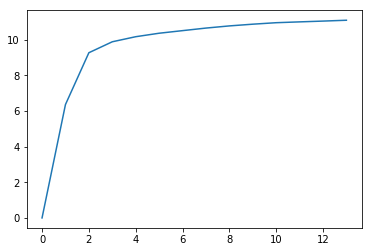

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

def elbow_chart(score):
    plt.plot(range(2,k),score[2:k]*100, marker='o', linestyle='--', linewidth=0.8)
    plt.ylabel("coverage (%)", fontsize=11)
    plt.xlabel("Number of scenarios", fontsize=11)
    plt.title("Coverage levels", fontsize=16)
    plt.axhline(y=90, color='r', linewidth=0.5, linestyle=':')
    plt.annotate('90%', xy=(2, 90), xytext=(-5, 10), textcoords='offset points', ha='left', va='top', color='r')
    plt.show()


# data set
df = pd.DataFrame({'temperature':data_norm[:,0],'precipitation': data_norm[:,1]})

# number of iterations
n = 15

kMeansVar = [KMeans(n_clusters=k).fit(df.values) for k in range(1, n)]
centroids = [X.cluster_centers_ for X in kMeansVar]
k_euclid = [cdist(df.values, cent) for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]

# distance squared sum (verifiy this math)
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(df.values)**2)/df.values.shape[0]
bss = tss - wcss
plt.plot(bss)
plt.show()



As often happens, the Elbow method has a not so obvious result. As we can see, the improviment of explained variance starts to decrease at 4 clusters and is almost constant from 6 elements. As expected, 5 clusters looks like the best value for k.

# The K-Means method

Over thes reescaled data set it is possible to apply K-means cluster from sklearn kit. Once we already know that data comes from 5 specific stations it is easy to choose the expected number of clusters. Note that it is not always easy to chose and there are specific techniques for this.

At the end, we use the original data set and not the scaled one to show the results in a more intuitive way.

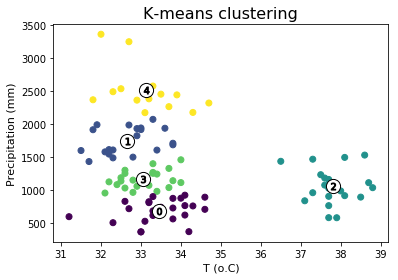

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# k means with 5 clusters
yPrediction = KMeans(n_clusters=5, random_state=random_state).fit_predict(data_norm)
yValues = KMeans(n_clusters=5, random_state=random_state).fit(data_norm)

# plotting
plt.scatter(data[:, 0], data[:, 1], c=yPrediction)
plt.title("Temp vs Precip")


#plt.scatter(a, b,  color='red', s=6)
#plt.plot(data['x'], model.predict(), color='black',  linewidth=0.8)
#name = 'Monthly TNx'
tLabelName = 'T (o.C)'
pLabelName = 'Precipitation (mm)'
plt.title("K-means clustering" , fontsize=16)
plt.ylabel(pLabelName, fontsize=11)
plt.xlabel(tLabelName, fontsize=11)

# Labeling the clusters
centers = min_max_scaler.inverse_transform(yValues.cluster_centers_)
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.show()


In [24]:
centers

array([[   33.4625    ,   685.675     ],
       [   32.66      ,  1740.18      ],
       [   37.805     ,  1054.895     ],
       [   33.05      ,  1156.74090909],
       [   33.13571429,  2508.04285714]])

Each pair is a centroid coordinate for 5 clusters. Now it is worthwhile take a look in the original labeled data characteristics. Lets compute the mean values for original precipitation and max temperature data

## The Silhouette method

According Wikipedia, Silhouette Analysis refers to a method of interpretation and validation of consistency within clusters of data. A graphical interpretation helps in  .It was first described by Peter J. Rousseeuw in 1986.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.


Silhouette Coefficient is formulated by considering both the intra- and inter-cluster
distances. For a given point $x_i$, first the average of the distances to all points in the same cluster is calculated. This value is set to a $a_i$. Then for each cluster that does not contain $x_i$, the average distance of $x_i$ to all the data points in each cluster is computed. This value is set to $b_i$. Using these two values the silhouette coefficient of a point is estimated. The average of all the silhouettes in the dataset is called the average silhouettes width for all the points in the dataset. To evaluate the quality of a clustering one can compute the average silhouette coefficient of all points. Mathematicaly

\begin{equation*}
S = \frac{1}{N} \sum_{i=1}^N \frac{(b_i - a_i)}{\max{(a_i,b_i)}}
\end{equation*}


If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.


The $S$ index over all data of a cluster is a measure of how tightly grouped all the data in the cluster are. It is a measure of how appropriately the data have been clustered. If there are too many or too few clusters, as may occur when a poor choice of $k$, some of the clusters will display narrower silhouettes than the rest. Thus silhouette plots and averages may be used to determine the natural number of clusters within a dataset.

Here ww used the Silhoute python code available in s


('For n_clusters =', 4, 'The average silhouette_score is :', 0.45203419199077816)


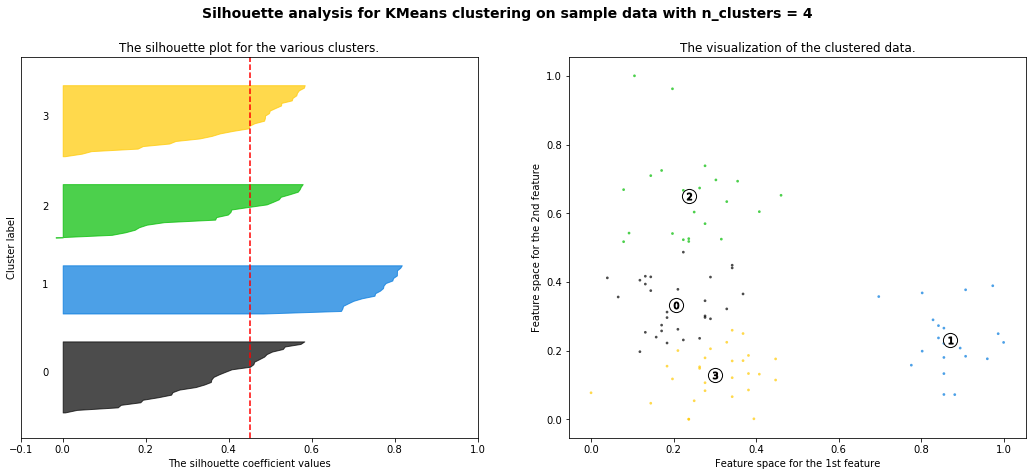

('For n_clusters =', 5, 'The average silhouette_score is :', 0.41596089490862181)


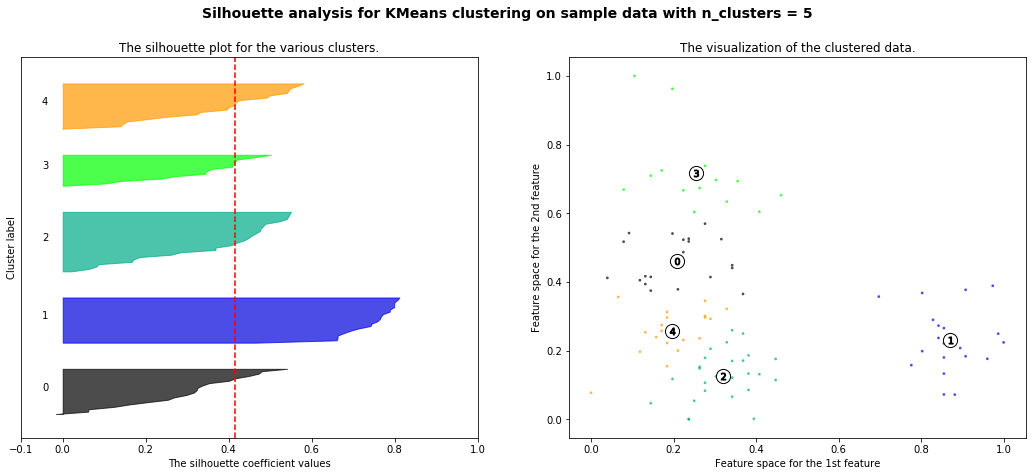

('For n_clusters =', 6, 'The average silhouette_score is :', 0.41653474003479396)


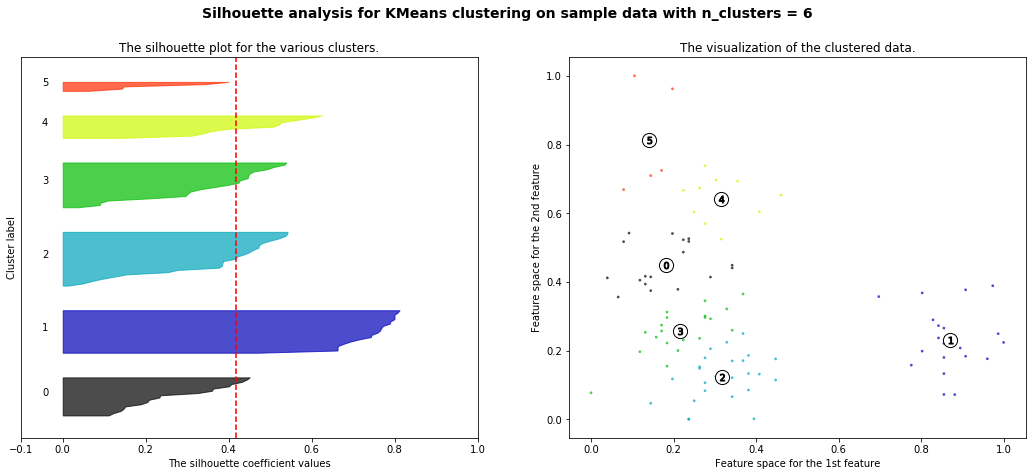

In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = data_norm

range_n_clusters = [4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

As silhouettes shows, 4 clusters looks a good choice but there are too much points in 0 and 4 clusters. The 6 clusters option creates a 5th labeled clustes a little unbalanced and under the mean. The most well balanced cluster is the 5 elements, with confirms what we alread knows about the data set. The silhouette index S does not say too much here, once they are ver similar for three simulations.

## Conclusions

Once we applied the segmentation method over the data we can check the validity of structure found by algorithm. 

The Elbow method results are not clear enought about the number of necessary clusters to structure the data set. It suggests something between 4 and 6. In this case another methods could be used to validate, and here we applyied the Silhouette method. By its results we conclude that 5 clusters are the optimal number of clusters to group this data set. Then, the segmentation was carried out and this yield the folloing centroids for each cluster



In [9]:
centroidsDenorm

array([[   33.4625    ,   685.675     ],
       [   32.66      ,  1740.18      ],
       [   37.805     ,  1054.895     ],
       [   33.05      ,  1156.74090909],
       [   33.13571429,  2508.04285714]])

Analysing the mean values for the temperatures and preciptation we can see som impressive results. 

In [8]:
np.mean(maxTemperature)

BARBALHA     37.805
CAMPINA      33.475
RECIFE       32.910
FORTALEZA    33.455
TRIUNFO      32.525
dtype: float64

In [9]:
np.mean(totalPrecip)

BARBALHA     1054.895
CAMPINA       790.105
RECIFE       2227.805
FORTALEZA    1483.455
TRIUNFO      1089.670
dtype: float64

Clearly the mean results reflects the expected method's outcomes. Each location has exactly the same mean values as its centroids obtained from method because the centroids ARE the means values of each locality. Supposing our data were not labeled, this tecnique would estimate correctly each location mean. By seeing the results from means we can say that yellow points are Recife observation as well are from Triunfo the green ones. The impressive results from grouping Barbalha shows the power of method.